# Encoder:
Forward: $\overrightarrow{h_{t}^{f}} = \overrightarrow{RNN}(embed(e_t), h_{t-1})$ <br/>
Backward: $\overleftarrow{h_{t}^{f}} = \overleftarrow{RNN}(embed(e_t), h_{t-1})$ <br/>
Concat: $h_{t}^{f} = [\overrightarrow{h_{t}^{f}}; \overleftarrow{h_{t}^{f}}]$ <br/>
All hidden states: $H^{f} = [h_{1}^{f}, h_{2}^{f}, ...., h_{|F|}^{f}]$

# Decoder:
$\overrightarrow{h_{t}^{e}} = \overrightarrow{RNN}([embed(e_{t-1}); c_{t-1}], h_{t-1})$ <br/>
$p^{t} = softmax(W_{hs}[\overrightarrow{h_{t}^{e}}; c_t] + b_s)$ <br/>
$p^{t} =$ $argmax$ $p^{t}$

# Attention:

Context Vector: $c_t = H^{f} * \alpha_t$ <br/>
Attention Scores: $\alpha_t = attentionScore(H^{f}, h_{t}^{e})$ <br/>
Normalized attention Scores: $\alpha_t = softmax(\alpha_t)$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import csv
import json
import copy
import os
from camel_tools.utils.normalize import normalize_unicode
import random
import numpy as np
import argparse
import matplotlib.pyplot as plt
import sacrebleu

In [2]:
class InputExample:
    """Simple object to encapsulate each data example"""
    def __init__(self, src, trg, 
                 src_g, trg_g):    
        self.src = src
        self.trg = trg
        self.src_g = src_g
        self.trg_g = trg_g
    
    def __repr__(self):
        return str(self.to_json_str())
    
    def to_json_str(self):
        return json.dumps(self.to_dict(), indent=2, ensure_ascii=False)
    
    def to_dict(self):
        output = copy.deepcopy(self.__dict__)
        return output

In [3]:
class RawDataset:
    """Encapsulates the raw examples in InputExample objects"""
    def __init__(self, data_dir):
        self.train_examples = self.get_train_examples(data_dir)
        self.dev_examples = self.get_dev_examples(data_dir)
        self.test_examples = self.get_dev_examples(data_dir)
        
    def create_examples(self, src_path, trg_path):
        
        src_txt = self.get_txt_examples(src_path)
        src_gender_labels = self.get_labels(src_path + '.label')
        trg_txt = self.get_txt_examples(trg_path)
        trg_gender_labels = self.get_labels(trg_path + '.label')
        
        examples = []
        
        for i in range(len(src_txt)):
            src = src_txt[i].strip()
            trg = trg_txt[i].strip()
            src_g = src_gender_labels[i].strip()
            trg_g = trg_gender_labels[i].strip()
            input_example = InputExample(src, trg, src_g, trg_g)
            examples.append(input_example)
        
        return examples
    
    def get_labels(self, data_dir):
        with open(data_dir) as f:
            return f.readlines()
        
    def get_txt_examples(self, data_dir):
        with open(data_dir, encoding='utf8') as f:
            return f.readlines()
    
    def get_train_examples(self, data_dir):
        """Reads the train examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-train.arin'), 
                                    os.path.join(data_dir, 'D-set-train.ar.M'))
    
    def get_dev_examples(self, data_dir):
        """Reads the dev examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-dev.arin'), 
                                    os.path.join(data_dir, 'D-set-dev.ar.M'))
    
    def get_test_examples(self, data_dir):
        """Reads the test examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-test.arin'), 
                                    os.path.join(data_dir, 'D-set-test.ar.M'))

In [4]:
raw_train = RawDataset('/home/ba63/gender-bias/christine_2019/Arabic-parallel-gender-corpus/').train_examples

In [5]:
raw_train[0]

{
  "src": "أريدها أن ترحل - فلنتخلص منها -",
  "trg": "أريدها أن ترحل - فلنتخلص منها -",
  "src_g": "B",
  "trg_g": "B"
}

In [6]:
class Vocabulary:
    """Vocabulary base class"""
    def __init__(self, token_to_index=None):
        
        if token_to_index is None:
            token_to_index = dict()
        
        self._token_to_index = token_to_index
        self._index_to_token = {i: t for t, i in self._token_to_index.items()}
        
    def add_token(self, token):
        """Adds a token"""
        if token in self._token_to_index:
            index = self._token_to_index[token]
        else:
            index = len(self._token_to_index)
            self._token_to_index[token] = index
            self._index_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Adds a list of token"""
        return [self.add_token(token) for token in tokens]
        
    def lookup_token(self, token):
        """Retrieves the index of the token"""
        return self._token_to_index[token]
    
    def lookup_index(self, index):
        """Retrieves the token of the index"""
        return self._index_to_token[index]
    
    def to_serializable(self):
        """Serializes a Vocabulary object"""
        return {'token_to_index': self._token_to_index}
    
    @classmethod
    def from_serializable(cls, contents):
        """Creates a vocab object from a serialized one"""
        cls(**contents)
    
    def __len__(self):
        return len(self._token_to_index)

In [7]:
class SeqVocab(Vocabulary):
    """Sequence Vocabulary"""
    def __init__(self, token_to_index=None, unk_token='<unk>',
                 pad_token='<pad>', sos_token='<sos>', eos_token='<eos>'):
        
        super(SeqVocab, self).__init__(token_to_index)
        self._unk_token = unk_token
        self._pad_token = pad_token
        self._sos_token = sos_token
        self._eos_token = eos_token
        
        self.pad_index = self.add_token(self._pad_token)
        self.unk_index = self.add_token(self._unk_token)
        self.sos_index = self.add_token(self._sos_token)
        self.eos_index = self.add_token(self._eos_token)
        
    def to_serializable(self):
        """Serializes a SeqVocab object"""
        contents = super(SeqVocab, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'pad_token': self._pad_token,
                         'sos_token': self._sos_token,
                         'eos_token': self._eos_token})
        return contents
    
    @classmethod
    def from_serializable(cls, contents):
        """Creates a SeqVocab object from a serialized one"""
        return cls(**contents)
    
    def lookup_token(self, token):
        """Retrieves the index of the token"""
        return self._token_to_index.get(token, self.unk_index)
    

In [8]:
class Vectorizer:
    """Vectorizer class"""
    def __init__(self, src_vocab, trg_vocab):
        self._src_vocab = src_vocab
        self._trg_vocab = trg_vocab
    
    @classmethod
    def create_vectorizer(cls, raw_dataset):
        """Creates a vectorizer from raw dataset examples"""
        src_vocab = SeqVocab()
        trg_vocab = SeqVocab()

        for ex in raw_dataset:
            src_tokens = ex.src.split(' ')
            trg_tokens = ex.trg.split(' ')

            for tok in src_tokens:
                src_vocab.add_token(tok)
            
            for tok in trg_tokens:
                trg_vocab.add_token(tok)
        
        return cls(src_vocab, trg_vocab)
    
    def get_src_indices(self, text):
        """Vectorizes the source text"""
        indices = [self._src_vocab.sos_index]
        indices.extend([self._src_vocab.lookup_token(token) for token in text.split(' ')])
        indices.append(self._src_vocab.eos_index)
        
        return torch.tensor(indices, dtype=torch.long)
    
    def get_trg_indices(self, text):
        """Creates two list of indices: 
            x_indices: the observations (inputs) in the target decoder.

            y_indices: the predictions in the target decoder.

            This technique is needed for teacher forcing
        """
        
        indices = [self._trg_vocab.lookup_token(token) for token in text.split(' ')]
        x_indices = [self._trg_vocab.sos_index] + indices
       
        y_indices = indices + [self._trg_vocab.eos_index]
        
        x_indices = torch.tensor(x_indices, dtype=torch.long)
        y_indices = torch.tensor(y_indices, dtype=torch.long)
        
        return x_indices, y_indices
            
    def vectorize(self, source_text, target_text):
        """Vectorizes the source text and the target text.
        
           The source will be just a single vector.
           The target will be two vectors. One is the observations (inputs)
           and the other is the predicitons
        """
        
        src_vector = self.get_src_indices(source_text)
        
        target_x_vector, target_y_vector = self.get_trg_indices(target_text)
        
        return {'src_vector': src_vector,
                'trg_x_vector': target_x_vector,
                'trg_y_vector': target_y_vector}
    
    def to_serializable(self):
        return {'src_vocab': self._src_vocab.to_serializable(),
                'trg_vocab': self._trg_vocab.to_serializable()}
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

In [9]:
vec = Vectorizer.create_vectorizer(raw_train)

In [10]:
class MT_Dataset(Dataset):
    """The torch dataset which wraps the data"""
    def __init__(self, raw_dataset, vectorizer):
        self._raw_dataset = raw_dataset
        self._vectorizer = vectorizer
        self.train_examples = self._raw_dataset.train_examples
        self.dev_examples = self._raw_dataset.dev_examples
        self.test_examples = self._raw_dataset.test_examples
        
        self.splits = {'train': self.train_examples,
                        'dev': self.dev_examples,
                        'test': self.test_examples
                      }
        
        self.set_split('train')

    @classmethod
    def load_dataset_and_create_vectorizer(cls, data_dir):
        raw_dataset = RawDataset(data_dir)
        return cls(raw_dataset, Vectorizer.create_vectorizer(raw_dataset.train_examples))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, data_dir, vectorizer_dir):
        raw_dataset = RawDataset(data_dir)
        vectorizer = cls.load_vectorizer(vectorizer_dir)
        return cls(raw_dataset, vectorizer)
    
    @staticmethod
    def load_vectorizer(vectorizer_dir):
        with open(vectorizer_dir) as fp:
            return Vectorizer.from_serializable(json.load(fp))
    
    def save_vectorizer(self, vectorizer_dir):
        with open(vectorizer_dir, 'w') as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
        
    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split):
        self.split = split
        self.split_examples = self.splits[split]
        
    def __len__(self):
        return len(self.split_examples)
    
    def __getitem__(self, index):
        src_text = self.split_examples[index].src
        trg_text = self.split_examples[index].trg
        
        vectorized = self._vectorizer.vectorize(src_text, trg_text)
        return vectorized

class Collator:
    """The main function which handles padding and sorting
    for each batch."""
    def __init__(self, src_pad_idx, trg_pad_idx):
        self._src_pad_idx = src_pad_idx
        self._trg_pad_idx = trg_pad_idx
        
    def __call__(self, batch):
        """Pads the source sequence (src_vector) up to the maximum
        source sequence length in the batch. Also pads both the 
        target sequences (trg_x_vector) and (trg_y_vector) up to the
        maximum target sequence in the batch.
        
        Sort the source sequences based on their lengths in the decending order"""
        
        # sorting the batch based on the src seqs length
        sorted_batch = sorted(batch, key=lambda x: len(x['src_vector']), reverse=True)
        
        src_seqs = [x['src_vector'] for x in sorted_batch]
        trg_x_seqs = [x['trg_x_vector'] for x in sorted_batch]
        trg_y_seqs = [x['trg_y_vector'] for x in sorted_batch]
        
        # getting the lengths of the src seqs
        src_seqs_lengths = torch.tensor([len(seq) for seq in src_seqs], dtype=torch.long)
        
        # padding the src and trg seqs
        padded_src_seqs = pad_sequence(src_seqs, batch_first=True, padding_value=self._src_pad_idx)
        padded_trg_x_seqs = pad_sequence(trg_x_seqs, batch_first=True, padding_value=self._trg_pad_idx)
        padded_trg_y_seqs = pad_sequence(trg_y_seqs, batch_first=True, padding_value=self._trg_pad_idx)
        
        return {'src': padded_src_seqs,
                'trg_x': padded_trg_x_seqs,
                'trg_y': padded_trg_y_seqs,
                'src_lengths': src_seqs_lengths
                }

In [11]:
class Encoder(nn.Module):
    """NMT bi-GRU Encoder"""
    def __init__(self, input_dim, embed_dim,
                 hidd_dim, src_padding_idx=0):
        
        super(Encoder, self).__init__()
        self.src_embedding = nn.Embedding(input_dim, embed_dim, padding_idx=src_padding_idx)
        self.rnn = nn.GRU(embed_dim, hidd_dim, bidirectional=True, batch_first=True)
    
    def forward(self, src_seqs, src_lengths):
        embedded = self.src_embedding(src_seqs) #embedded.shape: (batch_size, seq_len, embed_dim)
        packed_seqs = pack_padded_sequence(embedded, src_lengths, batch_first=True)
        
        outputs, hidden = self.rnn(packed_seqs) #outputs is a packed sequence
                                                #hidd.shape: (num_layers * num_directions, batch_size, hidd_dim)
            
        """Notes: Hidden is the last hidden state in the rnn and it's stored like
        [forward_layer_0;backward_layer_0;forward_layer_1;backward_layer_1......forward_layer_t..]"""
        
        # we need to reshape hidden to (batch_size, num_layers * num_directions * hidd_dim)
        hidden = hidden.permute(1, 0, 2) # changes the shape to: (batch_size, num_layers * num_directions, hidd_dim)
        
        # hidden.shape: (batch_size, num_layers * num_directions * hidd_dim)
        hidden = hidden.contiguous().view(hidden.shape[0], -1) 
        
        #unpacked_outputs.shape: (batch_size, seq_len, hidd_dim * num_directions)
        unpacked_outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        
        return unpacked_outputs, hidden

In [12]:
def attention(key_vectors, query_vector):
    """
    Args:
        - key_vectors: encoder hidden states (outputs). Shape: (batch_size, seq_len, hidd_dim * num_dirs)
        - query_vector: decoder hidden state (hidd). Shape: (batch_size, hidd_dim)
        - Note: hidd_dim of decoder == hidd_dim * num_dirs of encoder
    Returns:
        - context vectors
        - attention scores
        - attention probs
    """
    # attention score is a vector. To use torch.matmul, we need to broadcast query_vector 
    # to a third dimension. The last two dimensions of a tensor are always the matrix size!
    # So to make sure that attention_scores has a vector of each batch, we will introduce
    # a new dimension at dim=2. We will have (seq_len, hidd_dim * num_dirs) * (hidd_dim, 1)
    # this will lead us to a tensor of size (seq_len, 1) for each batch!!!!
    attention_scores = torch.matmul(key_vectors, query_vector.unsqueeze(2)).squeeze()
    
    # we turn the attention scores to probs
    attention_probs = F.softmax(attention_scores, dim=1)
    
    # we finally multiply the attention_probs with the key vectors to create context vector for each batch
    
    # each context vector, must have the same hidd_dim as the key_vectors and the query_vector.
    # to do that, we need to transpose the key_vectors and introduce a new dimension to attention_probs.
    # again, each batch will have its own context vector
    context_vectors = torch.matmul(key_vectors.transpose(-2,-1), attention_probs.unsqueeze(2)).squeeze()
    
    return context_vectors, attention_probs, attention_scores

In [13]:
class Decoder(nn.Module):
    """NMT GRU Decoder"""
    def __init__(self, input_dim, embed_dim,
                 hidd_dim, sos_token_idx, trg_padding_idx=0, dropout=0.3):
        
        super(Decoder, self).__init__()
        self._hidd_dim = hidd_dim
        self._sos_token_idx = sos_token_idx
        self.trg_embedding = nn.Embedding(input_dim, embed_dim, padding_idx=trg_padding_idx)
        #the input to the gru cell is the embedded token at time t + the context vector at t-1 
        # and the hidden state of the previous time step. So the input_dim is embed_dim + hidd_dim
        self.gru_cell = nn.GRUCell(embed_dim + hidd_dim, hidd_dim)
        self.linear_map = nn.Linear(hidd_dim, hidd_dim)
        #hidd_dim * 2 because we have a birnn in the encoder. input_dim as an output because
        #we want to predict over the entire vocabulary!
        self.classifier = nn.Linear(hidd_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout)
        
    def _init_indices(self, batch_size):
        """ return the <sos> index vector """
        return torch.ones(batch_size, dtype=torch.int64) * self._sos_token_idx
    
    def _init_context_vectors(self, batch_size):
        """ return a zeros vector for initializing the context """
        return torch.zeros(batch_size, self._hidd_dim)
    
    def forward(self, trg_seqs, encoder_state, initial_hidd_state):
        """The forward pass of the model
        
        Args:
            trg_seqs (torch.Tensor): the target text data tensor
            encoder_state (torch.Tensor): the output of the NMTEncoder (output vector)
            initial_hidden_state (torch.Tensor): The last hidden state in the Encoder (hidd_vector)
            
        Returns:
            output_vectors (torch.Tensor): prediction vectors at each output step
        """
        
        # at each time step we need a token in the target sequence
        # so we'll reshape to (seq_len, batch_size)
        trg_seqs = trg_seqs.permute(1, 0) #trg_seqs.shape: (seq_len, batch_size)
        trg_seq_length = trg_seqs.shape[0]
        
        # use the provided encoder hidden state as the initial hidden state. is this needed?
        h_t = self.linear_map(initial_hidd_state)
        
        batch_size = encoder_state.shape[0] #batch_size of the encoded src sequence
        
        #init the context vectors
        context_vectors = self._init_context_vectors(batch_size) #creating c_0 of shape:(batch_size, hidd_dim)
        
        # initialize first y_t (input to decoder) as <sos> token
        y_t_index = self._init_indices(batch_size)
        
        # auxiliries
        self.attention_scores = []
        self.attention_probs = []
        self.decoder_hidden_states = []
        output_vectors = []
        
        # moving data to right device
        h_t = h_t.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)
        y_t_index = y_t_index.to(y_t_index.device)
        
        for i in range(trg_seq_length): #shouldn't the loop be from 1 and not 0?
            y_t_index = trg_seqs[i]

            # Step 1: Embed word and concat with previous context
            y_input_vector = self.trg_embedding(y_t_index) #shape: batch_size, embedding_dim
            
            rnn_input = torch.cat((y_input_vector, context_vectors), dim=1)#shape: batch_size, embedding_dim + hidd_dim
            
            # Step 2: Do a single RNN step and obtain a new hidden state 
            h_t = self.gru_cell(rnn_input, h_t)

            self.decoder_hidden_states.append(h_t.cpu().detach().numpy())
            
            # Step 3: Compute attention scores and update the context vector
            context_vectors, attention_probs, attention_scores= \
                    attention(key_vectors=encoder_state, query_vector=h_t)

            self.attention_scores.append(attention_scores)
            self.attention_probs.append(attention_probs)
            
            # Step 4: Concat context_vectors with h_t and feed to a linear layer
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            
            # score_for_y_t_index is the prediction for the word at time t
            # which can be turned into a softmax and fed to a crossentropy loss
            
            score_for_y_t_index = self.classifier(self.dropout(prediction_vector))
            
            # auxillary: collect the prediction scores
            output_vectors.append(score_for_y_t_index)
            
            
        # each vector in output_vectors will have a shape of (batch_size, trg_vocab_size)
        # let's turn output_vectors to a tensor
        output_vectors = torch.stack(output_vectors) #shape: (trg_seq_len, batch_size, trg_vocab_size)
        # reshaping to (batch_size, trg_seq_len, trg_vocab_size)
        output_vectors = output_vectors.permute(1, 0, 2)
            
        return output_vectors
            

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, encoder_embedding_dim, 
                 encoder_hidd_dim, trg_vocab_size, decoder_embedding_dim,
                 sos_token_idx, src_padding_idx=0, trg_padding_idx=0):
        
        super(Seq2Seq, self).__init__()
        
        self.encoder = Encoder(input_dim=src_vocab_size, embed_dim=encoder_embedding_dim, 
                              hidd_dim=encoder_hidd_dim, src_padding_idx=src_padding_idx)
        
        # since at each time step will feed the context vector + the embedded output along
        # with the hidden state from the prev time step, so the hidden size of the decoder
        # must be the same as the hidden size of the encoder. Since we are using
        # a bidirectional encoder, the decoder hidd_dim will be encoder_hidd_dim * 2
        decoder_hidd_dim = encoder_hidd_dim * 2

        self.decoder = Decoder(input_dim=trg_vocab_size, embed_dim=decoder_embedding_dim,
                              hidd_dim=decoder_hidd_dim, sos_token_idx=sos_token_idx,
                              trg_padding_idx=trg_padding_idx)
                               
        
    def forward(self, src_seqs, src_lengths, trg_seqs):
        encoder_states, encoder_last_hidden_state = self.encoder(src_seqs, src_lengths)
        prediction_vectors = self.decoder(trg_seqs, encoder_states, encoder_last_hidden_state)
        
        return prediction_vectors

In [15]:
def set_seed(seed, cuda):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

In [16]:
args = argparse.Namespace(data_dir='/home/ba63/gender-bias/christine_2019/Arabic-parallel-gender-corpus/',
                          vectorizer_dir='/home/ba63/gender-bias/christine_2019/vectorizer',
                          model_path='//home/ba63/gender-bias/christine_2019/model.pt',
                          reload_from_files=False,
                          cuda=True,
                          batch_size=32,
                          seed=21,
                          encoder_embedding_dim=64,
                          decoder_embedding_dim=64,
                          encoder_hidd_dim=64,
                          learning_rate=5e-4,
                          num_epochs=50,
                          )

In [20]:
if args.reload_from_files:
    dataset = MT_Dataset.load_dataset_and_load_vectorizer(args.data_dir, args.vectorizer_dir)
else:
    dataset = MT_Dataset.load_dataset_and_create_vectorizer(args.data_dir)

vectorizer = dataset.get_vectorizer()

if not torch.cuda.is_available():
    args.cuda = False

device = torch.device('cuda' if args.cuda else 'cpu')
set_seed(args.seed, args.cuda)

In [96]:
model = Seq2Seq(src_vocab_size=len(vectorizer._src_vocab),
                encoder_embedding_dim=args.encoder_embedding_dim,
                encoder_hidd_dim=args.encoder_hidd_dim,
                trg_vocab_size=len(vectorizer._trg_vocab),
                decoder_embedding_dim=args.decoder_embedding_dim,
                sos_token_idx=vectorizer._trg_vocab.sos_index,
                src_padding_idx=vectorizer._src_vocab.pad_index,
                trg_padding_idx=vectorizer._trg_vocab.pad_index)

criterion = nn.CrossEntropyLoss(ignore_index=vectorizer._trg_vocab.pad_index)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

model = model.to(device)
criterion = criterion.to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (src_embedding): Embedding(13893, 64, padding_idx=0)
    (rnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (trg_embedding): Embedding(13603, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (linear_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=13603, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [97]:
def train(model, dataloader, criterion, optimizer, device='cpu'):
    
    epoch_loss = 0
    model.train()
    
    for batch in dataloader:
        optimizer.zero_grad()
        
        batch = {k: v.to(device) for k, v in batch.items()}
        
        src_seqs = batch['src']
        src_lengths = batch['src_lengths']
        x_target = batch['trg_x']
        y_target = batch['trg_y']

        preds = model(src_seqs, src_lengths, x_target)

        # CrossEntropyLoss accepts matrices always! 
        # the preds must be of size (N, C) where C is the number 
        # of classes and N is the number of samples. 
        # The ground truth must be a Vector of size C!
        
        preds = preds.contiguous().view(-1, preds.shape[-1])
        y_target = y_target.view(-1)
        
        loss = criterion(preds, y_target)
        
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return epoch_loss / len(dataloader)

In [98]:
def evaluate(model, dataloader, criterion, device='cpu'):
    
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:

            batch = {k: v.to(device) for k, v in batch.items()}

            src_seqs = batch['src']
            src_lengths = batch['src_lengths']
            x_target = batch['trg_x']
            y_target = batch['trg_y']

            preds = model(src_seqs, src_lengths, x_target)

            # CrossEntropyLoss accepts matrices always! 
            # the preds must be of size (N, C) where C is the number 
            # of classes and N is the number of samples. 
            # The ground truth must be a Vector of size C!

            preds = preds.contiguous().view(-1, preds.shape[-1])
            y_target = y_target.view(-1)

            loss = criterion(preds, y_target)

            epoch_loss += loss.item()

        return epoch_loss / len(dataloader)

In [99]:
num_epochs = args.num_epochs
set_seed(args.seed, args.cuda)
collate_fn = Collator(src_pad_idx=vectorizer._src_vocab.pad_index, trg_pad_idx=vectorizer._trg_vocab.pad_index)
train_losses = []
dev_losses = []
best_dev_loss = 1e8
for epoch in range(num_epochs):
    
    dataset.set_split('train')
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    train_loss = train(model, dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    dataset.set_split('dev')
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    dev_loss = evaluate(model, dataloader, criterion, device)
    dev_losses.append(dev_loss)
    
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), args.model_path)
        
    print(f"Epoch: {epoch + 1}")
    print(f"\tTrain Loss: {train_loss:.5}  |  Dev Loss: {dev_loss:.5}")

Epoch: 1
	Train Loss: 6.9653  |  Dev Loss: 6.5621
Epoch: 2
	Train Loss: 5.844  |  Dev Loss: 5.8958
Epoch: 3
	Train Loss: 4.9967  |  Dev Loss: 5.3376
Epoch: 4
	Train Loss: 4.2914  |  Dev Loss: 4.8881
Epoch: 5
	Train Loss: 3.6669  |  Dev Loss: 4.6444
Epoch: 6
	Train Loss: 3.1578  |  Dev Loss: 4.4201
Epoch: 7
	Train Loss: 2.6816  |  Dev Loss: 4.2508
Epoch: 8
	Train Loss: 2.2619  |  Dev Loss: 4.0707
Epoch: 9
	Train Loss: 1.9017  |  Dev Loss: 4.064
Epoch: 10
	Train Loss: 1.58  |  Dev Loss: 4.0547
Epoch: 11
	Train Loss: 1.3299  |  Dev Loss: 4.0296
Epoch: 12
	Train Loss: 1.0733  |  Dev Loss: 3.9069
Epoch: 13
	Train Loss: 0.83489  |  Dev Loss: 4.0589
Epoch: 14
	Train Loss: 0.68561  |  Dev Loss: 4.0002
Epoch: 15
	Train Loss: 0.55951  |  Dev Loss: 3.9524
Epoch: 16
	Train Loss: 0.4534  |  Dev Loss: 3.9835
Epoch: 17
	Train Loss: 0.33103  |  Dev Loss: 4.0252
Epoch: 18
	Train Loss: 0.25518  |  Dev Loss: 4.0655
Epoch: 19
	Train Loss: 0.22144  |  Dev Loss: 4.0524
Epoch: 20
	Train Loss: 0.16949  |  Dev

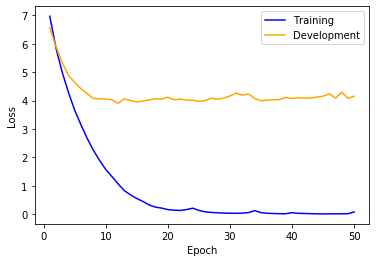

In [100]:
plt.plot(range(1, 1 + num_epochs), np.asarray(train_losses), 'b-', c='blue', label='Training')
plt.plot(range(1, 1 + num_epochs), np.asarray(dev_losses), 'b-', c='orange', label='Development')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [122]:
def get_sentence(vocab, vectorized_sentence, return_str=False):
    
    sentence = []
    for i in vectorized_sentence:
        if i == vocab.sos_index:
            continue
        elif i == vocab.eos_index:
            break
        else:
            sentence.append(vocab.lookup_index(i))
            
    if return_str:
        return ' '.join(sentence)
    else:
        return sentence
        
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.model = model
        self.vectorizer = vectorizer
        
    def get_info(self, batch):
        """Takes batch and returns a new batch with the model preds
        and attention probs"""
        
        self.sample_batch = batch
        
        src_seqs = batch['src']
        src_lengths = batch['src_lengths']
        x_target = batch['trg_x']
        y_target = batch['trg_y']

        preds = self.model(src_seqs, src_lengths, x_target)
        
        attention_probs = self.model.decoder.attention_probs
        #Note: Each tensor in attention probs has shape of: (batch_size, input_seq_len)
        # the number of tensors in attention_probs == the trg_seq_len
        attention_probs = torch.stack(attention_probs)
        #changing dimensions to (batch_size, trg_seq_len, input_seq_len)
        attention_probs = attention_probs.permute(1, 0, 2)
        
        self.sample_batch['preds'] = preds
        self.sample_batch['attention'] = attention_probs
        
        return self.sample_batch
    
    
    def get_predicted_sentence(self, index, return_str=True):
        # preds shape: (batch_size, trg_seq_len, trg_vocab)
        preds = self.sample_batch['preds']
        #let's find the target_vocab with the highest probs
        max_preds = torch.argmax(preds, dim=2)
        # max_preds shape: (batch_size, trg_seq_len)
        # let's a get a single sentence from the batch
        
        predicted_sentence = max_preds[index].cpu().detach().numpy()
        
        #let's convert the indices to a sentence
        return get_sentence(self.vectorizer._trg_vocab, predicted_sentence, return_str=return_str)
    
    def get_reference_sentence(self, index, return_str=True):
        #trg_sentences of shape (batch_size, trg_seq_len)
        trg_sentences = self.sample_batch['trg_y']
        
        # let's a get a single sentence from the batch
        trg_sentence = trg_sentences[index].cpu().detach().numpy()
        return get_sentence(self.vectorizer._trg_vocab, trg_sentence, return_str=return_str)
    
    def get_src_sentence(self, index, return_str=True):
        #src_sentences of shape (batch_size, src_seq_len)
        src_sentences = self.sample_batch['src']
        
        # let's a get a single sentence from the batch
        src_sentence = src_sentences[index].cpu().detach().numpy()
        return get_sentence(self.vectorizer._src_vocab, src_sentence, return_str=return_str)
    
    
    def get_ith_sample(self, index, return_str=True):
        output = {"src": self.get_src_sentence(index, return_str),
                  "reference": self.get_reference_sentence(index, return_str),
                  "prediction": self.get_predicted_sentence(index, return_str),
                  "attention": self.sample_batch['attention']}
        return output

In [141]:
model.eval()
dataset.set_split('test')
set_seed(args.seed, args.cuda)
dataloader = DataLoader(dataset, batch_size=args.batch_size, collate_fn=collate_fn)

In [142]:
sampler = NMTSampler(vectorizer, model)

In [143]:
refs = []
preds = []
for batch_num, batch in enumerate(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    
    sampler.get_info(batch)
    for i in range(args.batch_size):
        print("src", sampler.get_ith_sample(i)['src'])
        print("ref", sampler.get_ith_sample(i)['reference'])
        print("gen", sampler.get_ith_sample(i)['prediction'])
        print('\n')
        refs.append(sampler.get_ith_sample(i)['reference'])
        preds.append(sampler.get_ith_sample(i)['prediction'])
    #break

src أني لم <unk> الجنس منذ 15 عام يا ( <unk> ) ، أريد أن <unk> الجنس !
ref أني لم <unk> الجنس منذ 15 عام يا ( <unk> ) ، أريد أن <unk> الجنس !
gen أني لم يرجع الجنس منذ 15 عام ( ( ) ) ، أريد أن يجدوه الجنس !


src <unk> ) إهدأ لقد <unk> ) ويمكنني أن أرى قدوم ( ميمي ) زوجتك
ref <unk> ) إهدأ لقد <unk> ) ويمكنني أن أرى قدوم ( ميمي ) زوجتك
gen الطريقة ) اسم لقد اسم ) ويمكنني أن أرى


src اعني ما لم تكن <unk> <unk> التي <unk> عليها في <unk> تيري <unk>
ref اعني ما لم تكن <unk> <unk> التي <unk> عليها في <unk> تيري <unk>
gen اعني ما لم تكن حياة التي التي الطريقة عليها في الحجرة


src - أريد أن أشير إلى أنه لدينا أربعة <unk> <unk> <unk> -
ref - أريد أن أشير إلى أنه لدينا أربعة <unk> <unk> <unk> -
gen - أريد أن أسرع إلى أنه لدينا أربعة الطريقة - -


src سوف أعود أنا مع ( <unk> ) إلى المدينة هذه الليلة
ref سوف أعود أنا مع ( <unk> ) إلى المدينة هذه الليلة
gen سوف أعود أنا مع ( جيما ) إلى المدينة هذه الليلة


src إعتدت على جلب <unk> له و <unk> عندما <unk> <unk>
ref إعتدت على جلب <unk> له و <unk> عند

src <unk> <unk> أهل " البندقية " أسر فرسان " <unk> " . . . . . .
ref <unk> <unk> أهل " البندقية " أسر فرسان " <unk> " . . . . . .
gen تولت مقبولة أنا " اليد " " تعليمي " " " " . . . .


src أنا في <unk> <unk> ما <unk> بعض الناس . . . <unk> <unk> <unk> بواسطة
ref أنا في <unk> <unk> ما <unk> بعض الناس . . . <unk> <unk> <unk> بواسطة
gen أنا في اسم ما ما سجلناه بعض الناس . . .


src الحكومة تحتاج <unk> ، <unk> الشىء الوحيد المناسب لكى تعمل <unk> ، هل تفهم ؟
ref الحكومة تحتاج <unk> ، <unk> الشىء الوحيد المناسب لكى تعمل <unk> ، هل تفهم ؟
gen نعم ، ، ، الطريقة الشىء الوحيد حالكا كرئيس تعمل ، ، هل تفهم ؟


src كنت أتمنى ذلك لأن غدا هو عيد ميلادي لا ، أنا أتفهم ذلك حقا
ref كنت أتمنى ذلك لأن غدا هو عيد ميلادي لا ، أنا أتفهم ذلك حقا
gen كنت أتمنى ذلك لأن غدا هو عيد لا لا عيد أنا أتفهم ذلك حقا


src الآن . . <unk> الداخلية <unk> <unk> <unk> الأمريكية <unk> الجيش في مكتبي
ref الآن . . <unk> الداخلية <unk> <unk> <unk> الأمريكية <unk> الجيش في مكتبي
gen الآن . . عدا نائما الطريقة النادي سيأخذ بالطابق

src كلا ، بالطبع أنا أهتم <unk> ولكن لا أستطيع أن <unk> بذلك فى الحال ( وإلا سيقتل سيد ( تاكر
ref كلا ، بالطبع أنا أهتم <unk> ولكن لا أستطيع أن <unk> بذلك فى الحال ( وإلا سيقتل سيد ( تاكر
gen كلا ، بالطبع أنا أهتم ولكن لا لا أستطيع أن العدد الحال فى الحال ( مورا سيد ( ( روز


src ذات يوم <unk> ( <unk> ) من السجن ذهب إلى أحد <unk> . ذهبت إليه <unk>
ref ذات يوم <unk> ( <unk> ) من السجن ذهب إلى أحد <unk> . ذهبت إليه <unk>
gen ذات يوم الطريقة ( جوهان ) من السجن ذهب إلى . . إلى ذهبت إلى إلى إلى إلى إلى . .


src . . . عندما <unk> الطفل <unk> <unk> علي <unk> . حين إذ ، سأراه <unk>
ref . . . عندما <unk> الطفل <unk> <unk> علي <unk> . حين إذ ، سأراه <unk>
gen . . . عندما الطريقة الطفل الطريقة علي علي . ، حين ، ، ساذج فعلت


src <unk> الصغير " <unk> عليه " <unk> أيمكن أن <unk> أنهم <unk> ملابس <unk> ؟
ref <unk> الصغير " <unk> عليه " <unk> أيمكن أن <unk> أنهم <unk> ملابس <unk> ؟
gen الطريقة الصغير " اسم عليه " ميشيل حتى أن أعمل أنهم ملابس العزيز ؟ ؟


src أيمكنني أن <unk> على صديقي " السيد ( <unk

ref ! . . . أذا يمكنني أن <unk> من هذا
gen ! . . . . يمكنني أن اسم من هذا


src إذن أتريد مني أن أجعل شركتي <unk> له ؟
ref إذن أتريد مني أن أجعل شركتي <unk> له ؟
gen إذن أتريد مني أن أجعل كلية شريكي ؟ ؟


src في هذا الوقت ( <unk> من خريطة ( <unk>
ref في هذا الوقت ( <unk> من خريطة ( <unk>
gen في هذا الوقت ( ووهو من مراهق ( جوزيف


src أتمنى أن أجد 10 <unk> في المرة القادمة
ref أتمنى أن أجد 10 <unk> في المرة القادمة
gen أتمنى أن أجد 10 عام في المرة القادمة


src ألم أذكر لك بأننا <unk> حفلة <unk> ؟
ref ألم أذكر لك بأننا <unk> حفلة <unk> ؟
gen ألم أذكر لك بأننا الطريقة حفلة ؟ ؟


src <unk> <unk> " . . لكن لأجل الرحلة
ref <unk> <unk> " . . لكن لأجل الرحلة
gen الطريقة وليس " . . لكن لأجل الرحلة


src - هل <unk> علي ( <unk> ) ؟
ref - هل <unk> علي ( <unk> ) ؟
gen - هل الضرورى علي ( والذي ) ؟


src لدي أسوأ تصرف قد يتصرف به <unk> .
ref لدي أسوأ تصرف قد يتصرف به <unk> .
gen لدي أسوأ لست قد اختطفوا به .


src أعتقد أنه يجب علينا أن نتحرك .
ref أعتقد أنه يجب علينا أن نتحرك .
gen أعتقد أنه يجب علي

src لقد رأيت المستقبل يا سيد ( <unk> ) ، مرارا <unk> . . . <unk> منه شيئا واحدا . . . :
ref لقد رأيت المستقبل يا سيد ( <unk> ) ، مرارا <unk> . . . <unk> منه شيئا واحدا . . . :
gen لقد رأيت المستقبل يا سيد ( جيما ) ، . . . . . . منه واحدا . . . . :


src أنا شرطي . . . وهناك شرطي قد قتل . . . بسبب فمي الكبير .
ref أنا شرطي . . . وهناك شرطي قد قتل . . . بسبب فمي الكبير .
gen أنا شرطي . . . . . قد قتل . . . بسبب قد الكبير .


src لا أستطيع تصديق عدد الأشخاص الذين <unk> <unk> في هذه <unk> <unk>
ref لا أستطيع تصديق عدد الأشخاص الذين <unk> <unk> في هذه <unk> <unk>
gen لا أستطيع تصديق تصديق الأشخاص الطريقة مشكلة في في هذه الإتصالات


src ( حسنا ، <unk> ( فلوريدا <unk> عن الرجل <unk> بي
ref ( حسنا ، <unk> ( فلوريدا <unk> عن الرجل <unk> بي
gen ( حسنا ، الطريقة ( جوهان عام عن الرجل بي بي


src <unk> أن <unk> <unk> من إبني و بأنني قد أستسلم فحسب
ref <unk> أن <unk> <unk> من إبني و بأنني قد أستسلم فحسب
gen الطريقة أن اسم حياة من إبني بأنني بأنني قد فحسب فحسب


src أترى دون هو <unk> هو كان يظن أنه <

ref أيها السلحفاة ، اعطني هذا عندما تنتهي .
gen أيها السلحفاة ، اعطني هذا عندما . .


src دعني أرى إن كان هناك <unk> لي .
ref دعني أرى إن كان هناك <unk> لي .
gen دعني أرى إن كان هناك لي لي .


src هل رأيت أي شخص بمثل هذا الوصف ؟
ref هل رأيت أي شخص بمثل هذا الوصف ؟
gen هل رأيت أي شخص بمثل هذا الموضوع ؟


src ليس لدي أي شيء <unk> من أجله
ref ليس لدي أي شيء <unk> من أجله
gen ليس لدي أي شيء مشكلة من أجله


src " . . . لقد عدت "
ref " . . . لقد عدت "
gen " . . . لقد عدت "


src إنه شيء جميل أن أشارك سحري مع
ref إنه شيء جميل أن أشارك سحري مع
gen إنه شيء جميل أن أشارك معي مع


src كنت في <unk> <unk> رجلان أثناء وجودي
ref كنت في <unk> <unk> رجلان أثناء وجودي
gen كنت في اسم فترة رجلان أثناء علاجي


src و لم اكن في غرفة <unk>
ref و لم اكن في غرفة <unk>
gen و لم اكن في غرفة


src إنه <unk> واحد الآن ابقي معي
ref إنه <unk> واحد الآن ابقي معي
gen إنه اسم واحد الآن انا معي


src يجب ان اجد شئ <unk> ذلك
ref يجب ان اجد شئ <unk> ذلك
gen يجب ان اجد شئ حياة ذلك


src لا أعلم ما المقصود من ذلك
ref لا أعلم

src اذا سارت الامور بشكل جيد و عمل بجد ( لكنني أعرف ( <unk> ليس <unk> يعمل بجد
ref اذا سارت الامور بشكل جيد و عمل بجد ( لكنني أعرف ( <unk> ليس <unk> يعمل بجد
gen اذا كل الامور بشكل جيد و عمل - - لكنني أعرف ( يحضرونه نيويورك


src <unk> ، لم أكن أود أن أسمع ذلك فهذه <unk> أكثر من اللازم
ref <unk> ، لم أكن أود أن أسمع ذلك فهذه <unk> أكثر من اللازم
gen الطريقة ، لم أكن أود أن أسمع ذلك الأصابة أكثر أكثر من أجلي


src إحدى الرسائل كانت تقول " توقف عن مراسلة هاتفي يا جوردن "
ref إحدى الرسائل كانت تقول " توقف عن <unk> هاتفي يا جوردن "
gen الأرملة هذا كانت تقول " توقف عن متعة هاتفي يا " "


src استمعي ، دعيني أري ( آرتشي ) المكان ، حسنا ؟
ref استمعي ، دعيني أري ( آرتشي ) المكان ، حسنا ؟
gen استمعي ، دعيني لأرى ( كاتارا ) المكان ، حسنا ؟


src <unk> لي <unk> لهم بدلا من أن <unk> <unk> عليها
ref <unk> لي <unk> لهم بدلا من أن <unk> <unk> عليها
gen اسم لي هم لهم بدلا من أن يتهمني عليها


src <unk> لأني كذبت عليه ولكن كنت . . .
ref <unk> لأني كذبت عليه ولكن كنت . . .
gen الطريقة لأني كذبت عليه ولكن

src ما لدي هنا هو قطع <unk> صغيرة والتي - <unk> - سوف <unk> أن السيد ( جيمس <unk> )
ref ما لدي هنا هو قطع <unk> صغيرة والتي - <unk> - سوف <unk> أن السيد ( جيمس <unk> )
gen ما لدي هنا هو الضباب الطريقة صغيرة - صغيرة - صغيرة - - ما ( طلب جوزيف ) )


src كنت أعلم أن ( <unk> ) تحب النجوم ولكنني لم أظن ابدا أن <unk> كانت
ref كنت أعلم أن ( <unk> ) تحب النجوم ولكنني لم أظن ابدا أن <unk> كانت
gen كنت أعلم أن ( جوهان ) لوحة النجوم ولكنني لم يلتحق ابدا أن تحل كانت


src ربما لم اكن سعيدا <unk> مجرد بديل <unk> تاكر <unk> من وقت سحري
ref ربما لم اكن سعيدا <unk> مجرد بديل <unk> تاكر <unk> من وقت سحري
gen ربما لم اكن سعيدا اسم مجرد ستكون الطريقة ربما من من وقت سحري


src لا يزال لحم <unk> جيد . حسنا ، سأكون في <unk> .
ref لا يزال لحم <unk> جيد . حسنا ، سأكون في <unk> .
gen لا يزال لحم اسم جيد . حسنا ، سأكون في جز .


src نعم ، وأنا واثق كان مجرد <unk> الأولى من كل شيء .
ref نعم ، وأنا واثق كان مجرد <unk> الأولى من كل شيء .
gen نعم ، وأنا واثق كان اسم الأولى كل كل كل شيء .


src لست أنا وحدي ، في الو

src أنه فوق سيارتي
ref أنه فوق سيارتي
gen أنه فوق سيارتي


src - <unk> <unk>
ref - <unk> <unk>
gen - مضطر شريكي


src أي استثمار !
ref أي استثمار !
gen أي السابقة !


src لأن وجهي وسيم
ref لأن وجهي وسيم
gen لأن وجهي أفضل


src ما زلت آمل في الحصول على المشروبات المجانية <unk> التي <unk> على <unk> . في المستقبل المنظور
ref ما زلت آمل في الحصول على المشروبات المجانية <unk> التي <unk> على <unk> . في المستقبل المنظور
gen ما زلت آمل في الحصول على جلد بدون التي حصلت على على في في في يدعى


src حسنا ، الا الآن لم اعمل على كل التفاصيل ولكن عندما كنت . . <unk>
ref حسنا ، الا الآن لم اعمل على كل التفاصيل ولكن عندما كنت . . <unk>
gen حسنا ، ؟ الآن لم اعمل على كل التفاصيل ولكن عندما كنت . . .


src أعرف أحد <unk> والذي كان صديق مع عمال البناء و شرطي المرور
ref أعرف أحد <unk> والذي كان صديق مع عمال البناء و شرطي المرور
gen أعرف أحد اسم انا كان صديق مع كان صديق و شرطي


src <unk> في هذا <unk> من المعركة حتى وقت قريب جدا .
ref <unk> في هذا <unk> من المعركة حتى وقت قريب جدا .
gen آنضمي في هذا حياة من 

src أعني ، لقد قضيت طوال اليوم محاولة فهم ما حدث ،
ref أعني ، لقد قضيت طوال اليوم <unk> فهم ما حدث ،
gen أعني ، لقد قضيت طوال اليوم منذ ما ما حدث حدث


src أعني ، لقد قضيت طوال اليوم <unk> فهم ما حدث ،
ref أعني ، لقد قضيت طوال اليوم <unk> فهم ما حدث ،
gen أعني ، لقد قضيت طوال اليوم منذ ما ما حدث حدث


src أنا <unk> أن لا يعمل <unk> من <unk> القنينة .
ref أنا <unk> أن لا يعمل <unk> من <unk> القنينة .
gen أنا أخشي أن لا يعمل من من فقد القنينة .


src أنا <unk> أن لا يعمل <unk> من <unk> القنينة .
ref أنا <unk> أن لا يعمل <unk> من <unk> القنينة .
gen أنا أخشي أن لا يعمل من من فقد القنينة .


src أردت أن اكون مسؤلة عن طاولة <unk> في <unk> هندي
ref أردت أن اكون <unk> عن طاولة <unk> في <unk> هندي
gen أردت أن اكون عن عن طاولة كبير في نهر غادرنا


src أردت أن اكون <unk> عن طاولة <unk> في <unk> هندي
ref أردت أن اكون <unk> عن طاولة <unk> في <unk> هندي
gen أردت أن اكون الطريقة عن طاولة كبير في نهر غادرنا


src لا أرغب فى ان اكون <unk> لكننى بخير .
ref لا أرغب فى ان اكون <unk> لكننى بخير .
gen لا أ

ref أين <unk> - لا أعلم أنا لست <unk> -
gen أين - - لا أعلم أنا لست مفيدا -


src لا أستطيع <unk> <unk> لمدة أطول . آسف .
ref لا أستطيع <unk> <unk> لمدة أطول . آسف .
gen لا أستطيع القول لمدة لمدة أطول . آسف .


src لا أستطيع <unk> <unk> لمدة أطول . آسفة .
ref لا أستطيع <unk> <unk> لمدة أطول . آسف .
gen لا أستطيع القول لمدة أطول . . آسف .


src أنا أكثر من <unk> <unk> <unk> الليلة
ref أنا أكثر من <unk> <unk> <unk> الليلة
gen أنا أكثر من فضلك الليلة الليلة


src أنا أكثر من <unk> <unk> <unk> الليلة
ref أنا أكثر من <unk> <unk> <unk> الليلة
gen أنا أكثر من فضلك الليلة الليلة


src و أنا ، <unk> السيد <unk> ؟
ref و أنا ، <unk> السيد <unk> ؟
gen و أنا ، بداية السيد فلتشر ؟


src و أنا ، <unk> السيدة <unk> ؟
ref و أنا ، <unk> السيد <unk> ؟
gen و أنا ، الطريقة السيدة بإستثناء ؟


src انا اسف هل <unk> اصبحت <unk> ؟
ref انا اسف هل <unk> اصبحت <unk> ؟
gen انا اسف هل اكتشفتي قد ملكا ؟


src انا اسفة هل <unk> اصبحت <unk> ؟
ref انا اسف هل <unk> اصبحت <unk> ؟
gen انا اسف هل اكتشفتي اصبحت ملكا ؟


src

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [ ]:
bleu_score = sacrebleu.corpus_bleu(preds, [refs])

In [144]:
bleu_score.score

29.412070886890636